# Predicting Diabetes Using Logistic Regression Methods
## STAT 301 Final Project - Group 21 
**Ben Jia (94374246)     
Joshua Liu (45145604)     
Hrishi Logani (97201347)     
Yuyang Wen (89827711)**

***

## Contents:
- [Introduction](#Introduction)
- [Methods and Results](##Methods-&-Results)
    - [Description of Dataset](#Description-of-the-Data)
    - [Loading Packages](#Loading-Packages)
    - [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Methods](#Methods)
    - [Data Splitting](#Data-splitting)
    - [Variable Selection](#Variable-Selection)
    - [Model Fitting](#Model-Fitting)
- [Discussion & Conclusion](#Discussion)
    - [Conclusion](#Conclusion)
    - [Limitations](#Limitations)
    - [Future Direction](#Future-Direction)
- [References](#References)

***

## Introduction

Diabetes mellitus, more commonly known simply as diabetes, is a chronic disease that affects how the body generates energy from glucose. It develops either when the pancreas produces insufficient insulin, or cells in the body stop responding properly to insulin (CDC, n.d.). This causes excess blood sugar to remain in the bloodstream, causing serious health problems over time including heart and kidney problems. As of now, there is yet to be a cure for diabetes, and the prevalence of diabetes is steadily increasing over the past few decades, having doubled in cases since 1980 (WHO, 2016). Additionally, there are many different risk factors that are associated with diabetes, including family history, age, weight, diet, smoking, and ethnicity. 

Failing to recognize diabetes in its early stages contributes to the development of other health complications such as heart and kidney disease. Thus, it is vital to develop methods to predict the risk of diabetes in individuals. 

This leads us to our goal of answering the following question:
> **For females aged 21 and older in the Pima Indian population near Phoenix, Arizona, what linear combination of number of pregnancies, 2h-OGTT blood glucose, diastolic blood pressure, BMI, age, and family history of diabetes best predicts the diabetes milletus condition?**

Pima Indians are a group Native Americans that live in Mexico and Arizona, and were observed to have a high incidence rate of diabetes. Thus, it was thought that research centered around them would be significant not only to their group but also to global health (Chang et al., 2022)

***

## Methods & Results

### Description of the Data

Our dataset can be downloaded from https://www.kaggle.com/datasets/whenamancodes/predict-diabities. 

This dataset contains the medical data of 768 patients. These patients are all female, over the age of 21, and are of Pima Indian heritage. This dataset is a subset of a larger dataset collected by National Institute of Diabetes and Digestive and Kidney Diseases.

This dataset has 768 observations and 9 variables. 

##### **Table 1**: Descriptions of the Variables

| **Variable**             | **Data Type**        | **Description**                                                   |
|--------------------------|----------------------|-------------------------------------------------------------------|
| Pregnancies              | Discrete numerical   | Number of pregnancies                                             |
| Glucose                  | Continuous numerical | Plasma glucose concentration at 2 Hours in an Oral Glucose Tolerance Test (mg/dL)                             |
| BloodPressure            | Continuous numerical | Diastolic blood pressure in mmHg                                  |
| SkinThickness            | Continuous numerical | Triceps Skin Fold thickness (mm)                                              |
| Insulin                  | Continuous numerical | 2-hour serum insulin concentration (mIU/L   )                          |
| BMI                      | Continuous numerical | Body mass index                                                   |
| DiabetesPedigreeFunction | Continuous numerical | Predicted probability of diabetes based on age and family history |
| Age                      | Discrete numerical   | Age                                                               |
| Outcome                  | Binary               | Has diabetes = 1, no diabetes = 0                                 |

### Loading Packages

Before we begin, let us load all the necessary packages to perform our analysis:

In [1]:
shhh <- suppressPackageStartupMessages # It's a library, so shhh!

install.packages("ggcorrplot")
install.packages("Hmisc")

shhh(library(tidyverse))
shhh(library(GGally))
shhh(library(car))
shhh(library(glmnet))
shhh(library(leaps))
shhh(library(tidymodels))
shhh(library(ggpubr))
shhh(library(ggcorrplot))
shhh(library(Hmisc))
shhh(library(boot))
shhh(library(cowplot))

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘checkmate’, ‘cluster’, ‘htmlTable’, ‘viridis’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### Exploratory Data Analysis

Ultimately, we want to infer whether the available biometrical variables in the dataset can be used to predict the outcome (diabetes). Using more variables may result in a better (more accurate) model, and so, prior to the analysis, we want to use as many variables as feasible. 

Additionally, the original dataset contains some 'impossible' values (such as a `BMI` of 0). We noticed that all missing values are set as '0' in the original dataset. The following code cell sets the '0' values to `NA`.

In [2]:
diabetes <- read_csv("https://raw.githubusercontent.com/Ehsian/STAT-301-Project/main/diabetes.csv", show_col_types=FALSE) |> 
    mutate(Glucose = na_if(Glucose, 0),
           Insulin = na_if(Insulin, 0),
           BloodPressure = na_if(BloodPressure, 0),
           SkinThickness = na_if(SkinThickness, 0),
           BMI = na_if(BMI, 0))

head(diabetes, 3)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,NA,33.6,0.627,50,1
1,85,66,29,NA,26.6,0.351,31,0
8,183,64,NA,NA,23.3,0.672,32,1


##### **Table 2**: Diabetes Dataset (above)

In [3]:
glimpse(diabetes)

Rows: 768
Columns: 9
$ Pregnancies              <dbl> 6, 1, 8, 1, 0, 5, 3, 10, 2, 8, 4, 10, 10, 1, …
$ Glucose                  <dbl> 148, 85, 183, 89, 137, 116, 78, 115, 197, 125…
$ BloodPressure            <dbl> 72, 66, 64, 66, 40, 74, 50, NA, 70, 96, 92, 7…
$ SkinThickness            <dbl> 35, 29, NA, 23, 35, NA, 32, NA, 45, NA, NA, N…
$ Insulin                  <dbl> NA, NA, NA, 94, 168, NA, 88, NA, 543, NA, NA,…
$ BMI                      <dbl> 33.6, 26.6, 23.3, 28.1, 43.1, 25.6, 31.0, 35.…
$ DiabetesPedigreeFunction <dbl> 0.627, 0.351, 0.672, 0.167, 2.288, 0.201, 0.2…
$ Age                      <dbl> 50, 31, 32, 21, 33, 30, 26, 29, 53, 54, 30, 3…
$ Outcome                  <dbl> 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, …


We can then see the number of missing values for each variable:

In [4]:
diabetes |> summarize_all(~sum(is.na(.)))

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,5,35,227,374,11,0,0,0


##### **Table 3**: Total Missing Values for Each Variable (above)

Since there are 768 observations in the data, both `SkinThickness` and `Insulin` have too many missing values to be included in the model. It is possible that these values are **Missing Not At Random**; that is, missing values are actually correlated with the outcome. This could be because, for example, if someone shows no symptoms of diabetes, there is no reason for a doctor to order a bloodwork testing for insulin levels. This is a potential limitation for the inference and warrants further investigation. 

In [5]:
diabetes <- diabetes |>
    select(-SkinThickness, -Insulin)

Since we are using linear models to make inferences about the data, we should investigate the correlation between the variables. If there are highly correlated explanatory variables, we would consider removing all but one of them. If there is a variable that is not correlated with the outcome at all, then we might exclude it from the model too. We'll use a correlation plot to neatly visualize which variables are correlated with one another. 

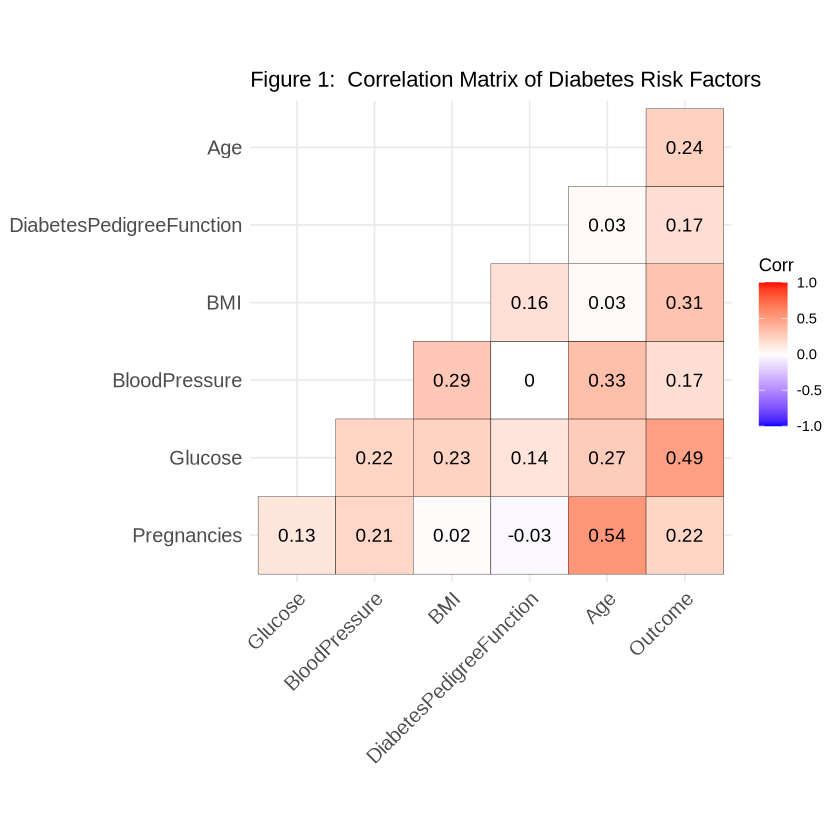

In [6]:
corr <- round(cor(diabetes, use="pairwise.complete.obs"), 2) # don't use NAs
ggcorrplot(corr, lab=TRUE, outline.color = "black", type="lower") +
ggtitle("Figure 1:  Correlation Matrix of Diabetes Risk Factors")

It appears that the highest correlated explanatory variables are `Age` and `Pregnancies`, with a correlation of 0.54. No variables have a correlation higher than the threshold of 0.6. So we will not need to drop any variables at this point. However, we bear in mind that there may be potentially multicollinearity problems and so we will check the VIFs of the explandatory variables after constructing a model.

We also want to investigate how the variables are distributed and whether there are extreme outliers. Outliers may negatively influence our model, so we want to identify if there are any and potentially remove them. For this, we will use a multi-histogram to visualize and compare the distributions of the explanatory variables. 

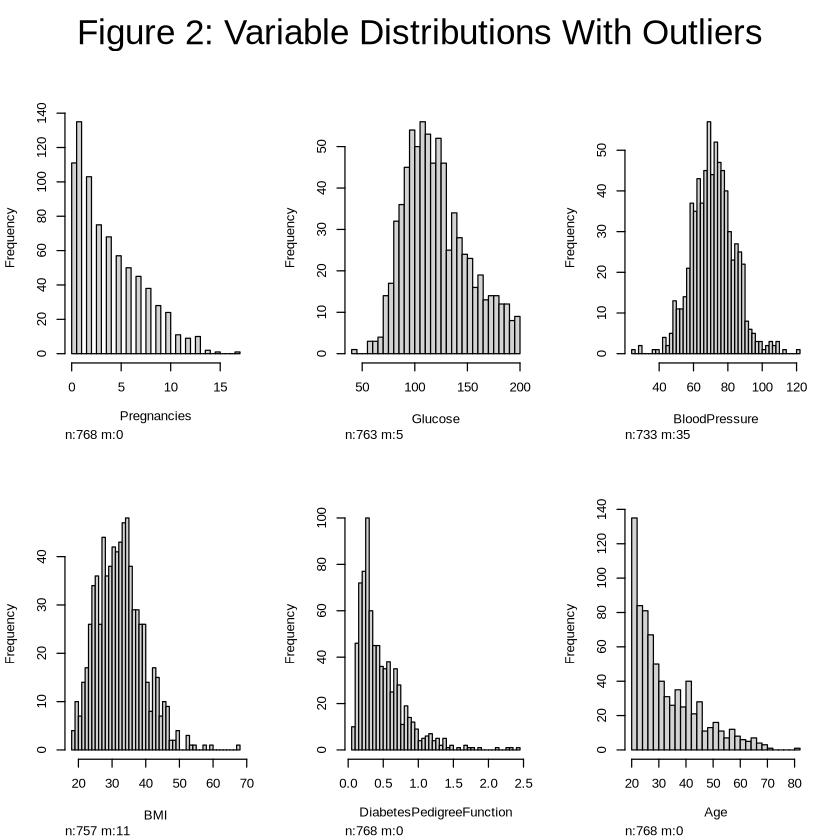

In [7]:
hist.data.frame(select(diabetes, -Outcome), mtitl="Figure 2: Variable Distributions With Outliers")

It appears that there are some outliers for `Blood Pressure`, and `BMI`. We'll remove those outliers. It also appears that `Pregnancy`, `Age`, and `DiabetesPedigreeFunction` are right-skewed. We'll keep that in mind for later.

In [8]:
diabetes <- diabetes |>
    filter(BloodPressure > 35) |>
    filter(BloodPressure < 120) |>
    filter(BMI < 55) |>
    filter(!is.na(Glucose)) |>
    mutate(Outcome = if_else(Outcome==0, "no diabetes", "diabetes")) |>
    mutate(Outcome = as.factor(Outcome))

nrow(diabetes)

[1] 717

We clipped off 51 observations, leaving us with 717 observations. Let's take a look at the distributions again.

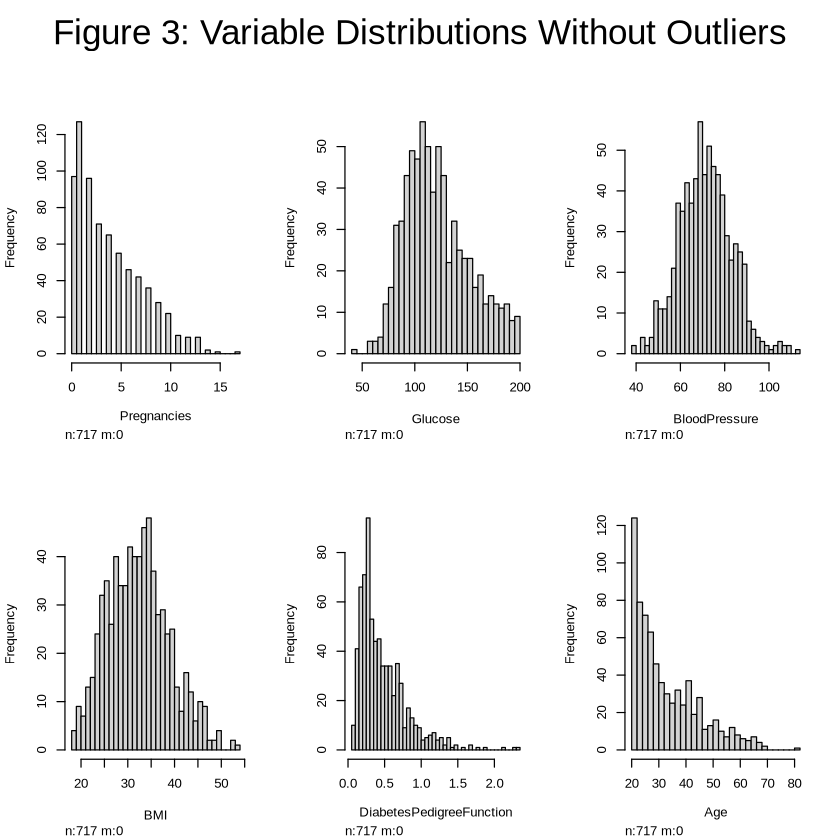

In [9]:
hist.data.frame(select(diabetes, -Outcome), mtitl="Figure 3: Variable Distributions Without Outliers")

Finally, let's take a look at the relationship between each variable and the outcome variable to get a sense on which variables we should expect to have a significant effect on the outcome.

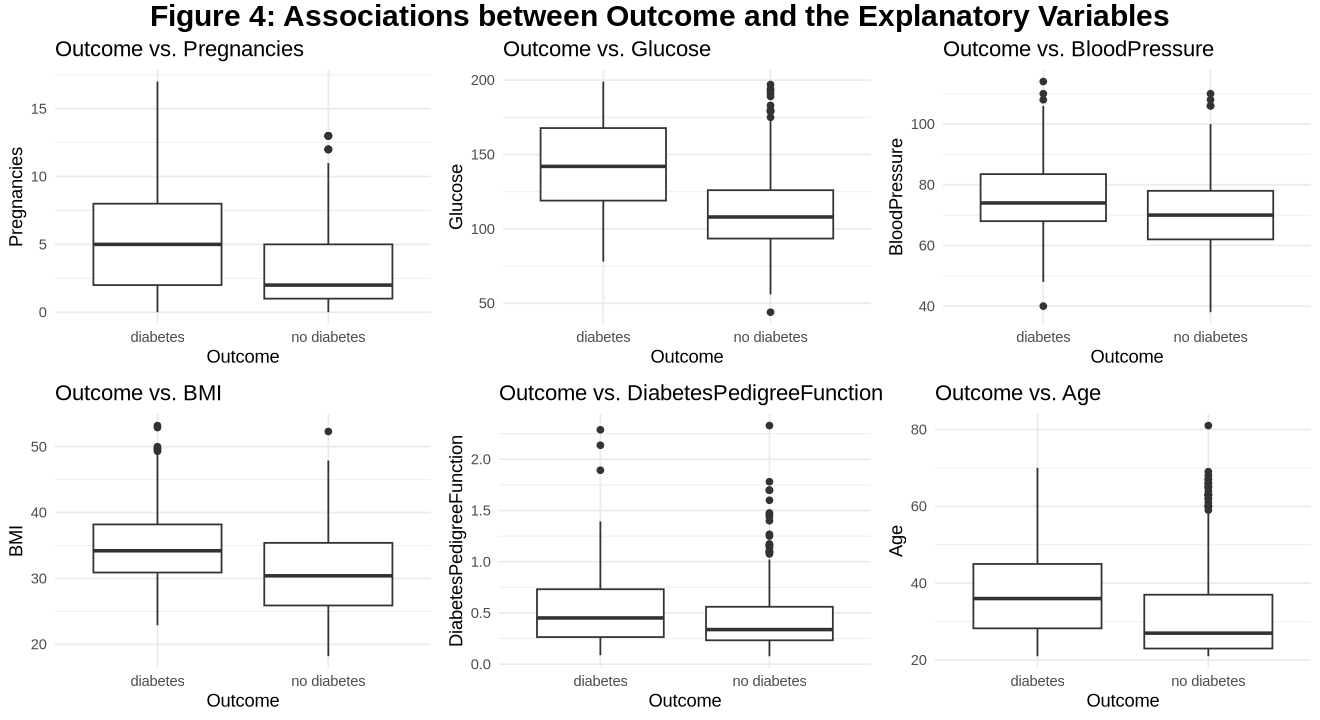

In [10]:
options(repr.plot.width = 11, repr.plot.height = 6)

plot_vs_outcome <- function(variable) {
    ggplot(diabetes, aes(x=Outcome, y=.data[[variable]])) +
    geom_boxplot() +
    theme_minimal() + 
    ggtitle(sprintf("Outcome vs. %s", variable))
}

associations <- plot_grid(
    plot_vs_outcome("Pregnancies"),
    plot_vs_outcome("Glucose"),
    plot_vs_outcome("BloodPressure"),
    plot_vs_outcome("BMI"),
    plot_vs_outcome("DiabetesPedigreeFunction"),
    plot_vs_outcome("Age"))

annotate_figure(associations, 
                top = text_grob("Figure 4: Associations between Outcome and the Explanatory Variables",
                               size=18, face="bold"))

It appears that `Glucose`, `BMI`, and `Age` may have the most significant effect on the outcome.

### Methods

To answer our inferential question, we will:
1. Split our data
2. Select the most important explanatory variables
3. Fit a logistic regression model

#### Data Splitting
Using the same data for variable selection and model fitting results in an increase in type I error. So, we will split our data into two parts: one part for selecting variables and one part for fitting the model. We chose to do a 20/80 split because we wanted more data to go into the inferential step.

In [11]:
set.seed(1)

# turn Outcome back into 1 and 0 for proportions
data <- diabetes |>
    mutate(Outcome = if_else(Outcome=="diabetes", 1, 0))

# split the data
diabetes_split <- initial_split(data, prop=0.2, strata=Outcome)
diabetes_selection <- training(diabetes_split)
diabetes_inference <- testing(diabetes_split)

#### Variable Selection

We used **backward selection** and the **Akaike information criterion (AIC)** to select for features. Backward selection is a simple, transparent, and reliable method to select for the best model while limiting model complexity, and so it is appropriate to use here. Backward selection is a greedy algorithm, so one main limitation is that it may not find the absolute best model. The AIC is a measure of prediction error based on information theory.  

In [12]:
# backwards selection 

full_model <- glm(
    formula = Outcome ~ .,
    data = diabetes_selection,
    family = "binomial")

selected_model <- stats::step(  # step uses AIC by default
    full_model,                 # backwards from full model
    direction = "backward",     # backward selection
    trace=0)                    # trace=1 to print the steps
 
selected_formula = formula(selected_model)
selected_formula

Outcome ~ Glucose + BMI + Age

The backwards selection algorithm selected `Glucose`, `BMI`, and `Age`. These were the three variables that appeared to be the most associated with `Outcome` in the EDA association plot.

#### Model Fitting
We fit a logistic regression model on the data set aside for inference. A logistic regression model will be used because the response variable is binary. We deliberately chose not to use shrinkage methods like Ridge or LASSO because we wanted to maintain the interpretability of the coefficients. Both Ridge and Lasso shrink the regression coefficients, which, though making the model less susceptible to overfitting and multicollinearity, obfuscates the real-world meaning of the coefficients. Using Ridge or Lasso, therefore, makes our inference less valuable. The tradeoff is that our model may be more susceptible to multicollinearity. However, as the correlation plot above does not shows, there does not appear to be high multicollinearity in this dataset. This is because we have removed the correlated variables in the data wrangling step already.

In [13]:
# use the features selected by backwards selection to fit the inference model
infer_model <- glm(
    formula = selected_formula,
    data = diabetes_inference,
    family = "binomial")

We inspect the model using `tidy()`, making sure to include confidence intervals and exponentiate the values for easier interpretation. 

In [14]:
# inspect the results
infer_model_results <- tidy(
    infer_model,
    conf.int=TRUE,
    exponentiate=TRUE) |>  # exponentiate for interpretability
    mutate_if(is.numeric, round, 3)

infer_model_results

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.000,0.823,-10.896,0.000,0.000,0.001
Glucose,1.036,0.004,8.961,0.000,1.028,1.044
BMI,1.093,0.017,5.109,0.000,1.057,1.132
Age,1.029,0.009,3.276,0.001,1.012,1.047


##### **Table 4**: Inference Model Results (above)

***

## Discussion

Our study aimed to predict diabetes mellitus in the Pima Indian population near Phoenix, Arizona, with the intent of focusing on the most pivotal variables. Through backward selection, we landed on `Glucose`, `BMI`, and `Age` as the most important predictors of diabetes in Pima Indian females aged 21 and older. The logistic regression model yielded insightful results, shedding light on crucial implications for healthcare interventions and future research endeavors.

The model coefficients unveiled that a unit increase in `Glucose` is linked to a 3.6% rise in the odds of diabetes, holding other variables constant. Similarly, a unit increase in `BMI` corresponds to a 9.3% increase in diabetes odds, while a unit rise in `Age` is associated with a 2.9% increase in diabetes odds (Table 3). These quantitative outcomes underscore the substantial influence of Glucose, BMI, and Age on diabetes prediction within the Pima Indian population.

Furthermore, the p-values associated with these variables are less than the significance level of 0.05, indicating their statistical significance and strong association with the outcome of interest. This statistical significance reinforces the reliability of the model's findings and underscores the robust relationship between `Glucose`, `BMI`, and `Age` with diabetes risk in the studied population.

Our study's outcomes align with our initial expectations, supported by EDA plots emphasizing the significance of these variables in diabetes prediction (Figure 4). By refraining from utilizing shrinkage methods like Ridge or LASSO, the model's robustness was maintained, ensuring the interpretability of coefficients and the practical relevance of variables in real-world contexts.

### Conclusion
In conclusion, our quantitative analysis highlights the pivotal roles of `Glucose`, `BMI`, and `Age` as fundamental predictors of diabetes within the Pima Indian population near Phoenix, Arizona. These variables have emerged as key determinants in predicting the likelihood of diabetes in females aged 21 and older from this specific demographic group.

By recognizing the significance of Glucose, BMI, and Age in diabetes prediction, we can leverage these findings to inform targeted healthcare interventions tailored to the unique characteristics of the Pima Indian population. Understanding the predictive power of these variables enables healthcare providers to proactively assess diabetes risk and implement preventive measures that cater to the specific needs of this population.

### Limitations 

While our analysis provides valuable insights, several limitations necessitate further exploration.  The generalizability of our findings is restricted by the dataset's focus on a specific demographic: Pima Indian females over 21 from near Phoenix. Additionally, the model's predictive power might be limited by the absence of variables such as genetic markers and detailed lifestyle information, potentially overlooking significant contributors to diabetes risk. Furthermore, our reliance on logistic regression, while effective here, may not fully capture the complexities of diabetes prediction. Exploring alternative modeling techniques or ensemble methods could offer a more nuanced understanding of how variables interact and influence diabetes outcomes.

Another point of concern is the potential 'Missing Not At Random' problem as proposed in the exploratory data analysis, where missing values might actually correlated with the outcome. It may be worth addressing this concern by checking whether or not the missing data is random, or if there is a reason why data is missing, which may potentially impact our findings.

Finally, the potential presence of unmeasured confounders or biases within the data could introduce uncertainties into the model's predictions. Addressing these limitations through sensitivity analyses or incorporating additional data sources could enhance the robustness and reliability of our findings.

By acknowledging these limitations and pursuing avenues for improvement, future research can build upon this foundation to develop more comprehensive and accurate models for predicting diabetes in the Pima Indian population. 

### Future Direction

Our study opens doors for further exploration. To improve our model's accuracy in predicting diabetes, we need to look deeper at how different factors work together. For instance, including information on diet and exercise could give us a more complete picture.

Future research should also consider the role of genes, environment, and cultural background specific to the Pima Indian community.  By taking a more holistic approach, we can gain a better understanding of why some people develop diabetes and how to prevent it. This knowledge can then be used to create personalized healthcare plans that truly meet the needs of the Pima Indian population in managing their health.

***

## References
Centers for Disease Control and Prevention. (n.d.). *Diabetes*. U.S. Department of Health and Human Services. Retrieved April 18, 2024 from https://www.cdc.gov/diabetes/basics/diabetes.html

Chang, V., Bailey, J., Xu, Q. A., & Sun, Z. (2022, March). *Pima Indians diabetes mellitus classification based on machine learning (ML) algorithms*. Neural computing & applications, 1–17. Advance online publication. Retrieved April 18, 2024 from https://doi.org/10.1007/s00521-022-07049-z 

Chauhan, A. (2022, November). *Predict Diabetes*. Retrieved April 15, 2024 from https://www.kaggle.com/datasets/whenamancodes/predict-diabities. 

Larabi-Marie-Sainte, S., Aburahmah, L., Almohaini, R., & Saba, T. (2019, October). *Current techniques for diabetes prediction: Review and case study*. MDPI. Retrieved April 18, 2024 from https://doi.org/10.3390/app9214604  

World Health Organization. (2016, April). *Global Report on Diabetes*. Retrieved April 18, 2024 from https://www.who.int/publications-detail/global-report-on-diabetes 